# ErrP Simulation and Denoising Example

This notebook is comprised of the simulation of EEG trials with and without error-related potentials (ErrPs); single-trial denoising of the EEG trials using the threshold-free wavelet packet transform-based denoising (TF-WPTD) method and the so-called NZT method [1]; and the root-mean-sqare-error (RMSE) measured from the simulated and denoised EEG trials.

## Requirements

MATLAB:
* Wavelet Toolbox
* Signal Processing Toolbox

Python >= 3.8:
* joblib>=1.1.0
* mne>=1.1.1
* numpy>=1.23.2
* scipy>=1.5.0
* scikit-learn>=0.23.1
* pandas
* seaborn
* statannotations
* notebook
* matlabengineforpython (see: https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

## Install

Create and enter a python virtual environment with python>=3.8:

```bash
conda create -n myenv python=3.8
conda activate myenv
```

Install required python libraries using pip (if your environment already supports jupyter notebook, you may delete "notebook" from requirement.txt):

```bash
pip install -r requirements.txt
```

Install matlab engine separately by following MathWorks' official documentation based on your MATLAB version:
https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

In MATLAB, add the "src_matlab" folder and its subfolders to the path. Also add the "data" folder to the path.

## How to run this notebook

Open this notebook using jupyter notebook, jupyterlab, VS Code, or equivalent. Execute all cells from top to bottom.

## References
[1] Maryam Ahmadi and Rodrigo Quian Quiroga. Automatic denoising of single-trial evoked
potentials. _NeuroImage_, 66:672–680, 2013.

# Import libraries, define utility functions and variables

In [1]:
import mne
import os
import joblib
import itertools
import matlab.engine
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
from scipy.io import loadmat
from statannotations.Annotator import Annotator

from src_python.denoisers import WaveletPacketDenoiser, NZTDenoiser

sns.set_style('ticks')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def data(filename=''):
    return op.join(os.getcwd(), 'data', filename)

def results(filename=''):
    return op.join(os.getcwd(), 'results', filename)

In [3]:
if not op.exists(results()):
    os.makedirs(results())

In [4]:
def format_joint_plot(fig, figsize=(7,3.5)):
    fig.set_size_inches(figsize)
    fig.get_axes()[0].set_xlabel('Time w.r.t. feedback onset (s)')
    fig.get_axes()[0].set_ylabel('Event Related Potential (μV)')

In [5]:
chs = [
    'Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 
    'CP1', 'CP5', 'PO7', 'P3', 'POz', 'PO3', 'O1', 'Oz', 
    'O2', 'PO4', 'P4', 'PO8', 'CP6', 'CP2', 'C4', 'T8', 
    'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'
]

In [6]:
info = mne.create_info(ch_names=chs, sfreq=256, ch_types='eeg').set_montage('biosemi64')

In [7]:
sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(info, 'eeg')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32


In [8]:
SNRs = [-20, -15, -10, -5, 0, 5, 10]

In [9]:
eng = matlab.engine.start_matlab(f"-sd '{data()}'")

# Simulate EEG trials

Make sure you have added "src_matlab", "data" and their subfolders to path in MATLAB.

In [10]:
# This shall take a while
eng.simulate_EEG(nargout=0)

In [11]:
eng.quit()

In [12]:
rmses = np.zeros((7,300))
for i, snr in enumerate(SNRs):
    print(f'SNR={snr}')
    dat = loadmat(data(f'simulated_EEG_SNR_{snr}.mat'))
    truth = dat['data']
    X = dat['noisy_data']

    rmse = np.sqrt(np.square(np.subtract(truth, X)).mean(axis=-1).mean(axis=-1))
    print(f'Mean RMSE: {rmse.mean()}')
    print()
    rmses[i,:] = rmse

np.save(results('RMSE_raw.npy'), rmses)

SNR=-20
Mean RMSE: 13.3892340315489

SNR=-15
Mean RMSE: 7.552090058167381

SNR=-10
Mean RMSE: 4.29842271198787

SNR=-5
Mean RMSE: 2.423558170550315

SNR=0
Mean RMSE: 1.3524595085141977

SNR=5
Mean RMSE: 0.7617731045116822

SNR=10
Mean RMSE: 0.4229787989290426



# Denoise

## Denoise with TF-WPTD

In [13]:
# This shall take a while
rmses = np.zeros((7,300))

for i, snr in enumerate(SNRs):
    print(f'SNR={snr}')

    # load simulated EEG
    dat = loadmat(data(f'simulated_EEG_SNR_{snr}.mat'))
    truth = dat['data']
    X = dat['noisy_data']
    events = np.array([[j+1, 0, 10 if j < 150 else 11] for j in range(300)])
    y = events[:,2]
    
    # denoise
    wp_denoisor = WaveletPacketDenoiser(
        coef_selection_method='all', 
        ch_adjacency=sensor_adjacency, 
        n_perm=100, 
        seed=42,
        n_jobs=-1
    )
    wp_denoisor.fit(X, y)
    joblib.dump(wp_denoisor, results(f'trained_TF-WPTD_SNR_{snr}.pkl'))
    
    X_denoised_full = wp_denoisor.transform(X)
    np.save(results(f'X_TF-WPTD_full_SNR_{snr}.npy'), X_denoised_full)
    
    X_denoised = np.zeros((300,32,307))
    for j, (x, label) in enumerate(zip(X_denoised_full, y)):
        if label==10: # success
            X_denoised[j,:,:] = x[:32,:]
        else: # failure
            X_denoised[j,:,:] = x[32:,:]
    np.save(results(f'X_TF-WPTD_SNR_{snr}.npy'), X_denoised)
    
    rmse = np.sqrt(np.square(np.subtract(truth, X_denoised)).mean(axis=-1).mean(axis=-1))
    print(f'Mean RMSE: {rmse.mean()}')
    print()
    rmses[i,:] = rmse

np.save(results('RMSE_TF-WPTD.npy'), rmses)

SNR=-20


c:\ProgramData\Anaconda3\envs\paper_supplementary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:28<00:00,    3.50it/s]
100%|██████████| Permuting : 99/99 [00:26<00:00,    3.76it/s]


Mean RMSE: 3.8779495455294923

SNR=-15


100%|██████████| Permuting : 99/99 [00:25<00:00,    3.91it/s]
100%|██████████| Permuting : 99/99 [00:25<00:00,    3.87it/s]


Mean RMSE: 2.705813114707743

SNR=-10


100%|██████████| Permuting : 99/99 [00:24<00:00,    4.04it/s]
100%|██████████| Permuting : 99/99 [00:24<00:00,    3.99it/s]


Mean RMSE: 1.7716118751419663

SNR=-5


100%|██████████| Permuting : 99/99 [00:24<00:00,    4.03it/s]
100%|██████████| Permuting : 99/99 [00:24<00:00,    4.00it/s]


Mean RMSE: 1.0919282502876988

SNR=0


100%|██████████| Permuting : 99/99 [00:24<00:00,    4.06it/s]
100%|██████████| Permuting : 99/99 [00:24<00:00,    4.04it/s]


Mean RMSE: 0.663819985630272

SNR=5


100%|██████████| Permuting : 99/99 [00:25<00:00,    3.94it/s]
100%|██████████| Permuting : 99/99 [00:24<00:00,    3.99it/s]


Mean RMSE: 0.40327387961039013

SNR=10


100%|██████████| Permuting : 99/99 [00:25<00:00,    3.95it/s]
100%|██████████| Permuting : 99/99 [00:25<00:00,    3.86it/s]


Mean RMSE: 0.24202123425546537



## Denoise with NZT

In [14]:
stim = 52 # First timepoint after 0s

In [15]:
# This shall take a while
rmses = np.zeros((7,300))

for i, snr in enumerate(SNRs):
    print(f'SNR={snr}')

    # load simulated EEG
    dat = loadmat(data(f'simulated_EEG_SNR_{snr}.mat'))
    truth = dat['data']
    X = dat['noisy_data']
    events = np.array([[j+1, 0, 10 if j < 150 else 11] for j in range(300)])
    y = events[:,2]
    
    # denoise
    nzt_denoisor = NZTDenoiser(
        coef_selection_method='all', 
        stim=stim
    )
    nzt_denoisor.fit(X, y)
    joblib.dump(nzt_denoisor, results(f'trained_NZT_SNR_{snr}.pkl'))
    
    X_denoised_full = nzt_denoisor.transform(X)
    np.save(results(f'X_NZT_full_SNR_{snr}.npy'), X_denoised_full)
    
    X_denoised = np.zeros((300,32,307))
    for j, (x, label) in enumerate(zip(X_denoised_full, y)):
        if label==10: # success
            X_denoised[j,:,:] = x[:32,:]
        else: # failure
            X_denoised[j,:,:] = x[32:,:]
    np.save(results(f'X_NZT_SNR_{snr}.npy'), X_denoised)
    
    rmse = np.sqrt(np.square(np.subtract(truth, X_denoised)).mean(axis=-1).mean(axis=-1))
    print(f'Mean RMSE: {rmse.mean()}')
    print()
    rmses[i,:] = rmse

np.save(results('RMSE_NZT.npy'), rmses)

SNR=-20
Mean RMSE: 8.361742102974373

SNR=-15
Mean RMSE: 4.80895757110053

SNR=-10
Mean RMSE: 2.771849137153544

SNR=-5
Mean RMSE: 1.6135741683667524

SNR=0
Mean RMSE: 0.8890819746683273

SNR=5
Mean RMSE: 0.49878759069572226

SNR=10
Mean RMSE: 0.2802341889268656



# RMSE comparison

In [16]:
def get_rmse_df(filename, method):
    rmses = np.load(results(filename))
    df = pd.DataFrame(rmses.T, columns=[f'RMSE_{s}' for s in SNRs])
    df['Trial'] = np.arange(300)
    
    df = pd.wide_to_long(
        df, ['RMSE'], i='Trial', j='SNR', sep='_', suffix=r'[-]?\d+'
    ).reset_index()
    
    df['Method'] = method
    return df

rmse_tf_wptd = get_rmse_df('RMSE_TF-WPTD.npy', 'TF-WPTD')
rmse_nzt = get_rmse_df('RMSE_NZT.npy', 'NZT')
rmse_raw = get_rmse_df('RMSE_raw.npy', 'Raw')

rmse_df = pd.concat([rmse_raw, rmse_nzt, rmse_tf_wptd], axis=0).reset_index(drop=True)
print(rmse_df.shape)
rmse_df.head()

(6300, 4)


,Trial,SNR,RMSE,Method
0,0,-20,13.867146,Raw
1,1,-20,13.313093,Raw
2,2,-20,12.831062,Raw
3,3,-20,13.451342,Raw
4,4,-20,13.235642,Raw


[[(-20, 'Raw'), (-20, 'NZT')], [(-15, 'Raw'), (-15, 'NZT')], [(-10, 'Raw'), (-10, 'NZT')], [(-5, 'Raw'), (-5, 'NZT')], [(0, 'Raw'), (0, 'NZT')], [(5, 'Raw'), (5, 'NZT')], [(10, 'Raw'), (10, 'NZT')], [(-20, 'Raw'), (-20, 'TF-WPTD')], [(-15, 'Raw'), (-15, 'TF-WPTD')], [(-10, 'Raw'), (-10, 'TF-WPTD')], [(-5, 'Raw'), (-5, 'TF-WPTD')], [(0, 'Raw'), (0, 'TF-WPTD')], [(5, 'Raw'), (5, 'TF-WPTD')], [(10, 'Raw'), (10, 'TF-WPTD')], [(-20, 'NZT'), (-20, 'TF-WPTD')], [(-15, 'NZT'), (-15, 'TF-WPTD')], [(-10, 'NZT'), (-10, 'TF-WPTD')], [(-5, 'NZT'), (-5, 'TF-WPTD')], [(0, 'NZT'), (0, 'TF-WPTD')], [(5, 'NZT'), (5, 'TF-WPTD')], [(10, 'NZT'), (10, 'TF-WPTD')]]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-10_Raw vs. -10_NZT: t-test paired samples, P_val:0.000e+00 t=2.594e+02
-5_Raw vs. -5_NZT: t-test paired samples, P_val:2.157e-301 t=1.725e+02
0_Raw vs. 0_NZT: t-test p

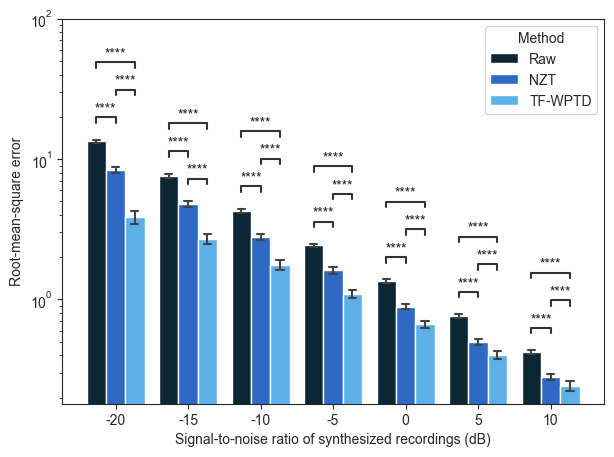

In [17]:
fig,ax = plt.subplots(figsize=(7,5))
sns.barplot(data=rmse_df, x='SNR', y='RMSE', hue='Method', ci='sd', 
            capsize=0.1, errwidth=1.5, ax=ax, palette=['#06283D', '#1363DF', '#47B5FF'])
ax.set_yscale('log')

pairs=[[(snr, p1), (snr, p2)] for p1, p2 in itertools.combinations(['Raw', 'NZT', 'TF-WPTD'],2) for snr in SNRs]
print(pairs)

annotator = Annotator(ax, pairs, data=rmse_df, x='SNR', y='RMSE', hue='Method')
annotator.configure(test='t-test_paired', text_format='star')
annotator.apply_and_annotate()

ax.set_xlabel('Signal-to-noise ratio of synthesized recordings (dB)')
ax.set_ylabel('Root-mean-square error')
ax.set_ylim(None, 100)

plt.show()

# ERP visualisation (SNR=-15 dB)

In [18]:
dat = loadmat(data('simulated_EEG_SNR_-15.mat'))
X_truth = dat['data']
X_noisy = dat['noisy_data']
X_tf_wptd = np.load(results('X_TF-WPTD_SNR_-15.npy'))
X_nzt = np.load(results('X_NZT_SNR_-15.npy'))

kwargs = dict(
    events=[[i+1,0,10 if i < 150 else 11] for i in range(300)], 
    tmin=-0.2, 
    event_id={'success':10, 'failure':11}
)

epochs_truth = mne.EpochsArray(X_truth*1e-6, info, **kwargs)
epochs_noisy = mne.EpochsArray(X_noisy*1e-6, info, **kwargs)
epochs_tf_wptd = mne.EpochsArray(X_tf_wptd*1e-6, info, **kwargs)
epochs_nzt = mne.EpochsArray(X_nzt*1e-6, info, **kwargs)

Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated


success
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


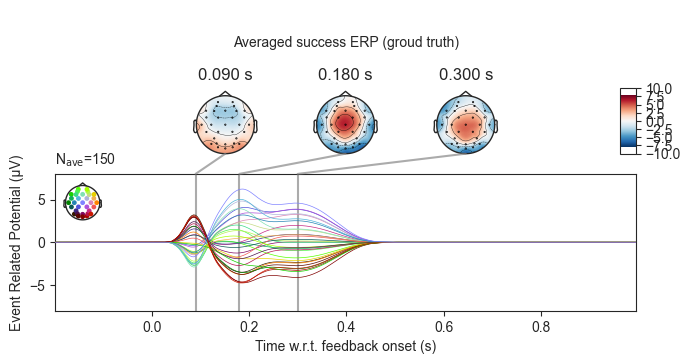

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


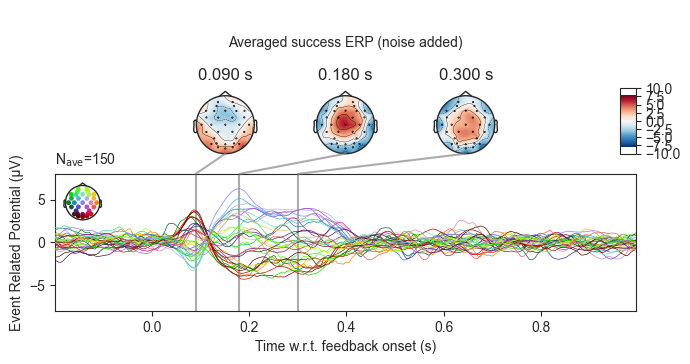

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


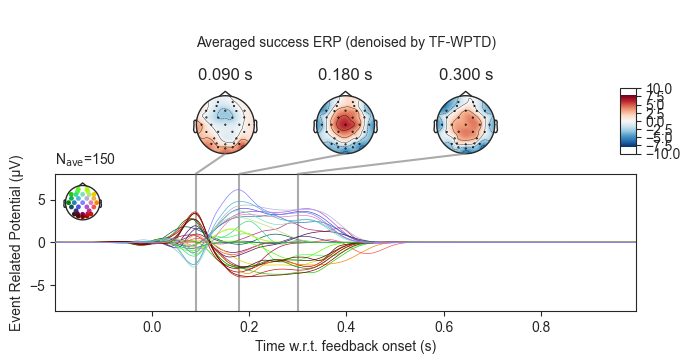

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


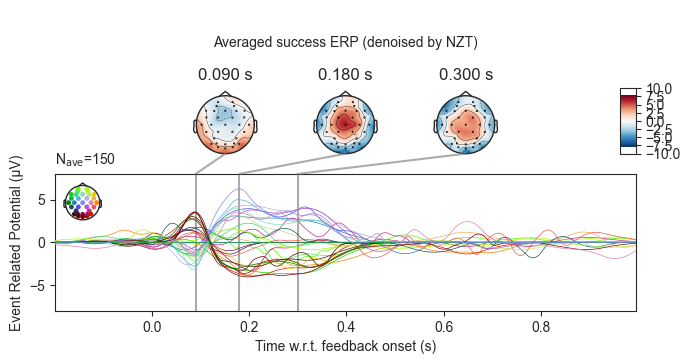

failure
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


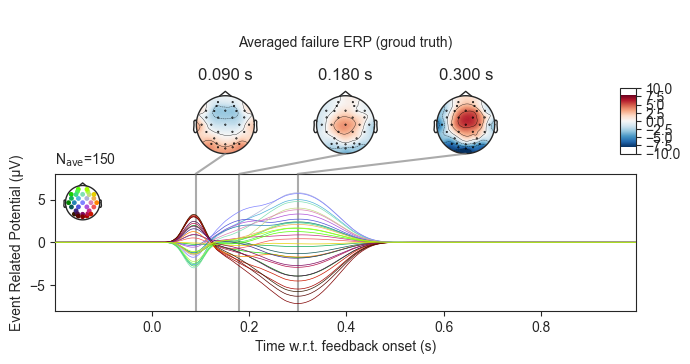

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


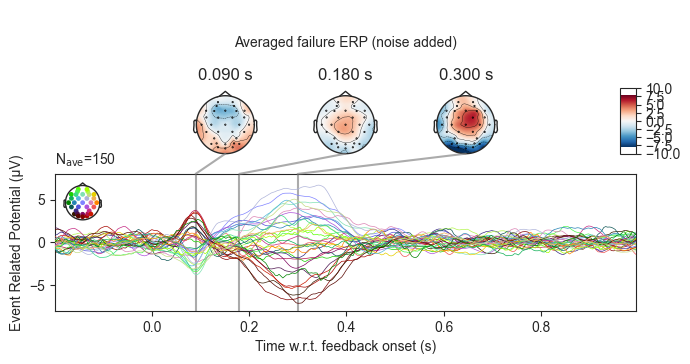

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


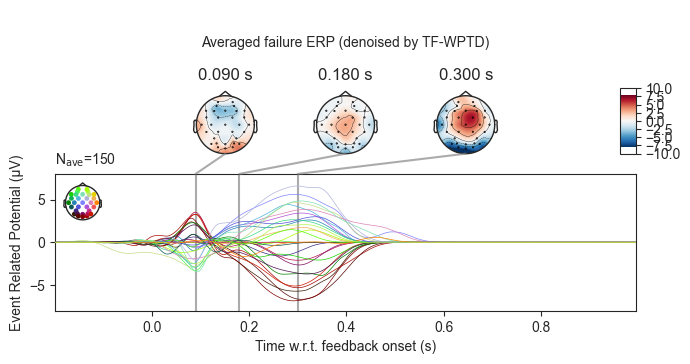

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


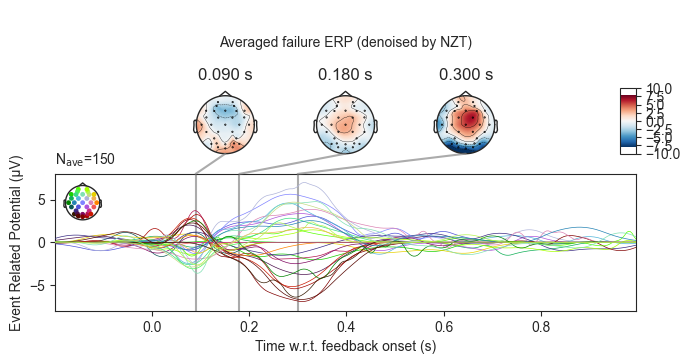

In [19]:
def plot_erp(evoked, title):
    kwargs = dict(
        times=[0.09,0.18,0.3],
        ts_args=dict(ylim={'eeg':[-8, 8]}), 
        topomap_args={'vlim':(-8, 8)}, 
        show=False
    )

    fig = evoked.plot_joint(title=title, **kwargs)
    format_joint_plot(fig)
    plt.show()

print("success")
plot_erp(epochs_truth['success'].average(), 'Averaged success ERP (groud truth)')
plot_erp(epochs_noisy['success'].average(), 'Averaged success ERP (noise added)')
plot_erp(epochs_tf_wptd['success'].average(), 'Averaged success ERP (denoised by TF-WPTD)')
plot_erp(epochs_nzt['success'].average(), 'Averaged success ERP (denoised by NZT)')

print("failure")
plot_erp(epochs_truth['failure'].average(), 'Averaged failure ERP (groud truth)')
plot_erp(epochs_noisy['failure'].average(), 'Averaged failure ERP (noise added)')
plot_erp(epochs_tf_wptd['failure'].average(), 'Averaged failure ERP (denoised by TF-WPTD)')
plot_erp(epochs_nzt['failure'].average(), 'Averaged failure ERP (denoised by NZT)')